<a href="https://colab.research.google.com/github/Carambolushka/Simpsons/blob/main/Simpson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#! unzip -q '/content/drive/My Drive/Симпсоны/journey-springfield.zip'

In [ ]:
import torch
import numpy as np
import pickle
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline



In [ ]:
gpu_train = torch.cuda.is_available()

if not gpu_train:
    print('Обучаем на CPU')
else:
    print('Обучаем на GPU')

Обучаем на GPU


In [ ]:
data_modes = ['train', 'test', 'val']
rescale_img = 224
DEV = torch.device('cuda')

In [ ]:
class Simpsons(Dataset):
    def __init__(self, files, mode):
        super().__init__()
        self.files = sorted(files)
        self.mode = mode

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('labels.pkl', 'wb') as label_set:
                pickle.dump(self.label_encoder, label_set)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        img = Image.open(file)
        img.load()
        return img

    def prepare_sample(self, img):
        img_resize = img.resize((rescale_img, rescale_img))
        return np.array(img_resize)

    def __getitem__(self, index):
        transform_image = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])
        ])

        x = self.load_sample(self.files[index])
        x = self.prepare_sample(x)
        x = np.array(x/255, dtype='float32')
        x = transform_image(x)
        if self.mode == 'test':
            return x
        else:
            label_img = self.labels[index]
            label_img_index = self.label_encoder.transform([label_img])
            y = label_img_index.item()
        return x, y
        

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [ ]:
train_dir = Path('/content/train/simpsons_dataset')
test_dir = Path('/content/testset/testset')

train_files = sorted(list(train_dir.rglob('*.jpg')))
test_files = sorted(list(test_dir.rglob('*.jpg')))

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train_labels = [path.parent.name for path in train_files]

train_data, validation_data = train_test_split(train_files,
                                               test_size = 0.25,
                                               stratify = train_labels)

In [ ]:
validation_set = Simpsons(validation_data, mode= 'val')
train_set = Simpsons(train_data, mode = 'train')
test_set = Simpsons(test_files, mode = 'test')

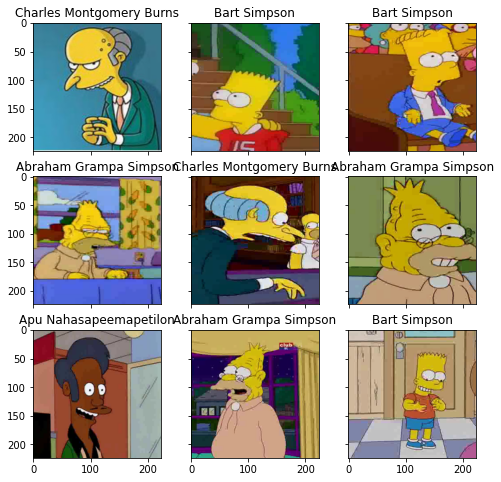

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = validation_set[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
               validation_set.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, n_class):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, 
                      out_channels=8,
                      kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, 
                      out_channels=16,
                      kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, 
                      out_channels=32,
                      kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, 
                      out_channels=64,
                      kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, 
                      out_channels=96,
                      kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.out = nn.Linear(in_features=5*5*96, out_features = n_class)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0),-1)
        mery = self.out(x)
        return mery

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer):
    now_loss = 0.0
    now_true = 0.0
    now_data = 0.0

    for x,y_true in train_loader:
        x = x.to(DEV)
        y_true = y_true.to(DEV)

        optimizer.zero_grad()

        y_preds = model(x)

        loss = criterion(y_preds, y_true)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(y_preds, 1)
        now_loss += loss.item() * x.size(0)
        now_true += torch.sum(preds == y_true)
        now_data += x.size(0)

    train_loss = now_loss/now_data
    train_accuracy = now_true.cpu().numpy() / now_data
    return train_loss, train_accuracy 

In [ ]:
def eval_epoch(model, validation_loader, criterion):
    model.eval()
    now_loss = 0
    now_true = 0
    now_data = 0

    for x,y_true in validation_loader:
        x = x.to(DEV)
        y_true = y_true.to(DEV)

        with torch.no_grad():
            y_preds = model(x)
            loss = criterion(y_preds, y_true)
            preds = torch.argmax(y_preds, 1)
            now_loss += loss.item() * x.size(0)
            now_true += torch.sum(preds == y_true)
            now_data += x.size(0)

    val_loss = now_loss/now_data
    val_accuracy = now_true.double() / now_data
    return val_loss, val_accuracy 

In [ ]:
def train_model(train_file, val_file, model, epochs, batch_size):

    history = []

    with tqdm(desc='epoch', total = epochs) as pbar_outer:
         optim = torch.optim.Adam(model.parameters())
         criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        
        train_loss, train_accuracy = fit_epoch(model, train_loader, criterion, optim)
        print(f'train loss: {train_loss}')

        val_loss, val_accuracy = eval_epoch(model, val_loader, criterion)

        history.append((train_loss, train_accuracy, val_loss, val_accuracy))

        pbar_outer.update(1)
        
        log_teamplate = f'эпоха: {epoch},\
        train_loss: {train_loss},\
        train accuracy: {train_accuracy},\
        val loss: {val_loss},\
        val accuracy: {val_accuracy}'
        print(log_teamplate)
    return history

In [ ]:
test_loader = DataLoader(test_set, batch_size= 64, shuffle=False)
def predict(model, test_loader):    
    with torch.no_grad():
        mery = []
        for x in test_loader:
            x = x.to(DEV)
            model.eval()
            y_preds = model(x).cpu()
            mery.append(y_preds)

    maybe = nn.functional.softmax(torch.cat(mery), dim= -1).numpy()
    return maybe

In [ ]:
n_class = len(np.unique(train_labels))
simple_cnn = SimpleCNN(n_class).to(DEV)

In [ ]:
history = train_model(train_set, validation_set, model = simple_cnn, epochs = 2, batch_size = 64)

epoch:   0%|          | 0/2 [00:00<?, ?it/s]


train loss: 2.7155110386497876
эпоха: 0,        train_loss: 2.7155110386497876,        train accuracy: 0.24683100834448055,        val loss: 2.124778718952008,        val accuracy: 0.4195643867023309
train loss: 1.7618879893986508
эпоха: 1,        train_loss: 1.7618879893986508,        train accuracy: 0.5269125422001402,        val loss: 1.4858213092336046,        val accuracy: 0.6029805120366832


In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

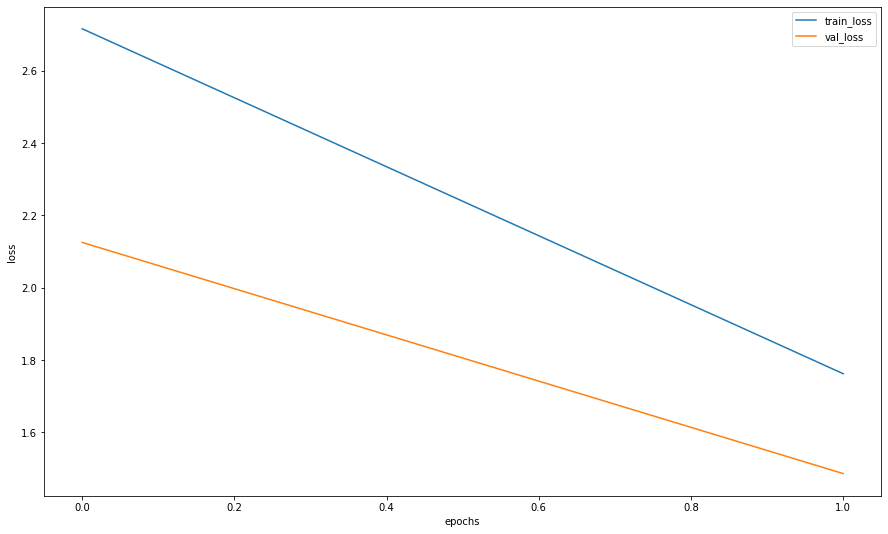

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
def pred_one_img(model, input_img, device=DEV):
    
    with torch.no_grad():
        input_img = input_img.to(device)
        model.eval()
        mery = model(input_img).cpu()

        mery_to_ver = nn.functional.softmax(mery, dim= -1).numpy()
    return mery_to_ver

In [ ]:
rand_pers = list(map(int, np.random.uniform(0,1000,50)))

imgs = [validation_set[id][0].unsqueeze(0) for id in rand_pers]

probs_ims = predict(simple_cnn, imgs)

In [ ]:
label_encoder = pickle.load(open("labels.pkl", 'rb'))

In [ ]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [validation_set[id][1] for id in rand_pers]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [ ]:
y_pred
actual_labels
sum(y_pred == actual_labels)/50

0.48

In [ ]:
from sklearn.metrics import f1_score
f1_score(actual_labels, y_pred, average= 'micro')

0.48

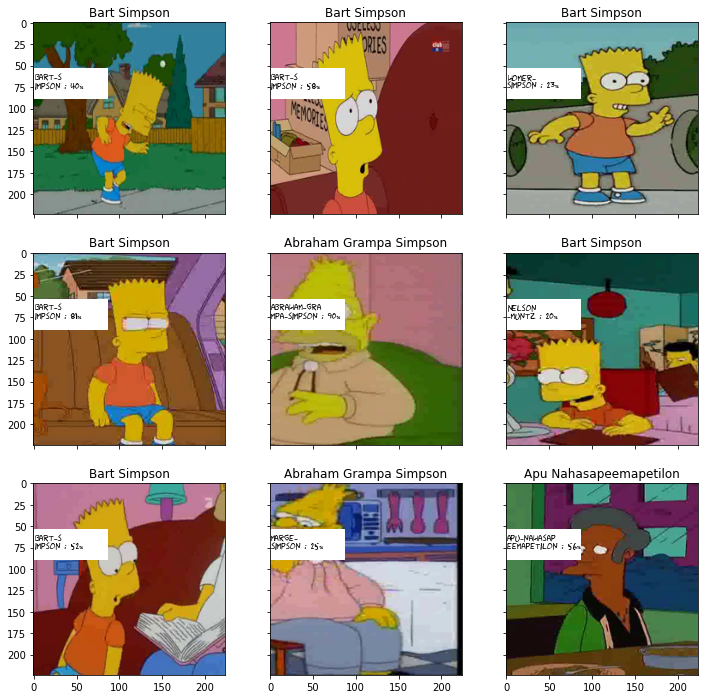

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = validation_set[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                validation_set.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = pred_one_img(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

In [ ]:
probs = predict(simple_cnn, test_loader=test_loader)


In [ ]:
preds = label_encoder.inverse_transform(np.argmax(probs, axis= 1))

In [ ]:
test_file_name = [path.name for path in test_set.files]

In [ ]:
import pandas as pd

In [ ]:
sub = pd.DataFrame({"ID":test_file_name, "Expected":preds})
sub.to_csv('Sub.csv')